# Overview

In this lesson, we explore the fundamentals of raster data analysis and processing using Python, focusing on both elevation models and satellite imagery. We’ll cover practical geospatial techniques such as raster classification, slope analysis, and essential raster operations. The lesson integrates popular geospatial libraries like [rioxarray](https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html), [rasterio](https://rasterio.readthedocs.io/en/latest/), and [xarray](https://xarray.pydata.org/en/stable/) for efficient data handling and analysis.

## Learning Goals:

- Import and visualize raster data 
- Merging rasters and mossaicing them together (stitching)
- Clipping rasters
- Raster classification 
- Raster analysi operations
- Perform raster calculations




# Exploring Raster Data in Python

Raster data is a grid-based data structure composed of rows and columns of cells (or pixels), where each cell represents a single value. While often associated with images, raster datasets can also be stored in various formats such as **ASCII text files** or **Binary Large Objects (BLOBs)** within databases.

[ESRI - What is Raster Data](https://desktop.arcgis.com/en/arcmap/latest/manage-data/raster-and-images/what-is-raster-data.htm)*

## Understanding Raster Data

Raster data models the world as a grid of uniformly sized cells, with each cell containing a value that represents specific information, such as temperature, elevation, or land cover. There are two primary types of raster data:

- **Single-band raster**: Each pixel holds a single value, representing a specific attribute (e.g., elevation or temperature).
- **Multiband raster**: Each pixel contains multiple values, commonly used in satellite imagery (e.g., Red, Green, and Blue bands).

### Resolution: A Key Characteristic

One of the most important attributes of raster data is its **resolution**, which defines the real-world ground distance represented by each cell. For instance, a raster with a resolution of 2 meters means each cell corresponds to a 2m × 2m area. Higher-resolution raster datasets provide finer details but result in larger file sizes.

## Common Raster Data Formats

Raster data can be stored in various **file formats**, each with its own advantages and use cases:

- **TIFF (Tagged Image File Format)**: A widely used geospatial raster format due to its flexibility. TIFF files support multiple bands, metadata storage, and internal compression. However, they may have compatibility issues across different software.
- **JPEG, GIF, BMP, PNG**: Common image formats suitable for visualization and online applications. However, they lack essential geospatial metadata, making them less ideal for analytical purposes.
- **ASCII Grid**: A text-based format often used for elevation data, storing numerical values with spatial metadata in the file header.

By understanding the structure and formats of raster data, you can efficiently process and analyze geospatial information in Python.


## Loading raster data

We will use a satellite image for this lesson ((https://dataspace.copernicus.eu), as well as a Digital Elevation Model (DEM)

## 🛰️ Introduction to Sentinel-2

Sentinel-2 is a **multispectral optical satellite mission** from the European Space Agency (ESA), designed primarily for **land monitoring**. It provides **high-resolution images** useful for agriculture, forestry, land cover mapping, and climate studies.

### 📊 Sentinel-2 Characteristics
- **Spatial Resolution**: 10m, 20m, or 60m depending on the band
- **Spectral Bands**:
  - **10m**: B2 (Blue), B3 (Green), B4 (Red), B8 (NIR)
  - **20m**: B5, B6, B7 (Red Edge), B8A, B11, B12 (SWIR)
  - **60m**: B1 (Coastal), B9 (Water Vapor), B10 (Cirrus)
- **Temporal Resolution**: Every **5 days** (with both Sentinel-2A & 2B)




## 📌 Sentinel-2 Bands We Are Loading
In our analysis, we are using the following **Sentinel-2 bands**:

| **Band Name** | **Band Number** | **Wavelength (nm)** | **Resolution (m)** | **Description** |
|--------------|----------------|------------------|----------------|----------------|
| **Blue** | `B2` | 490 | 10m | Useful for water analysis and atmospheric correction |
| **Green** | `B3` | 560 | 10m | Sensitive to vegetation (chlorophyll absorption) |
| **Red** | `B4` | 665 | 10m | Helps distinguish vegetation and urban areas |
| **Near-Infrared (NIR)** | `B8` | 842 | 10m | Useful for vegetation health and NDVI calculation |

### 🎯 **Why These Bands?**
- **RGB Composite (`B4`, `B3`, `B2`)** → True color image (looks like a natural photograph).
- **False Color Composite (`B8`, `B4`, `B3`)** → Enhances vegetation, making plants appear bright.
- **NIR (`B8`)** → Helps in vegetation analysis (NDVI), detecting land cover changes.



import rasterio
import xarray
import rioxarray

print(rasterio.__version__)
print(xarray.__version__)
print(rioxarray.__version__)
# 🌍 Digital Elevation Model (DEM) – Copernicus GLO-30

## 🛰️ Overview of Copernicus DEM (GLO-30)
The **Copernicus Global Digital Elevation Model (GLO-30)** is a high-resolution elevation dataset provided by the **European Space Agency (ESA)**. It offers **30-meter spatial resolution** worldwide, making it one of the best global DEMs for terrain analysis.

### 📌 **Key Features of Copernicus GLO-30**
- **Spatial Resolution**: 30 meters (1 arc-second)
- **Coverage**: Global (all latitudes, including polar regions)
- **Data Type**: Float32 (elevation in meters)
- **Vertical Reference**: EGM2008 geoid
- **Source**: Derived from multiple sources, including TanDEM-X radar data

---


## 🖥️ **Applications of DEM Data**
Digital Elevation Models are used in many geospatial analyses, including:
- 🌋 **Terrain Analysis** (hills, valleys, elevation profiles)
- 🌊 **Hydrology & Flood Modeling** (watersheds, drainage networks)
- 🏗️ **Urban Planning & Infrastructure Development**
- 🚀 **Remote Sensing Applications** (land classification, erosion modeling)
- 🛰️ **3D Visualization & Simulations** (hillshade, terrain rendering)




# 📌 Loading Single-Band Raster Data

## 🖥️ What is `rioxarray` https://corteva.github.io/rioxarray/stable/ ?
`rioxarray` is a powerful library for handling raster data in Python. It is built on top of `xarray` and `rasterio`, allowing seamless integration with geospatial analysis workflows.  

### 🔍 **How Does `rioxarray` Work?**
- **Uses `rasterio` https://rasterio.readthedocs.io/en/stable/  under the hood** to read raster file formats like **GeoTIFF**.
- **Loads raster data into an `xarray.DataArray`**, enabling **easy manipulation, visualization, and analysis**.
- **Supports CRS (Coordinate Reference Systems) & metadata handling**, making it ideal for geospatial processing.

### 📂 **Why Use `rioxarray` for Single-Band Raster Data?**
✅ Reads raster files efficiently  
✅ Preserves geospatial metadata (CRS, extent, resolution)  
✅ Works seamlessly with `xarray` https://docs.xarray.dev/en/stable/  for multidimensional analysis  
✅ Supports on-the-fly reprojecting and clipping  



In [2]:
import rioxarray

raster_file = 'data/Stockholm_DEM.TIF'

# Load a single-band raster
elevation_raster = rioxarray.open_rasterio(raster_file)

In [3]:
print (elevation_raster)

<xarray.DataArray (band: 1, y: 224, x: 372)> Size: 333kB
[83328 values with dtype=float32]
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 3kB 18.02 18.02 18.02 18.02 ... 18.12 18.12 18.12
  * y            (y) float64 2kB 59.36 59.36 59.36 59.36 ... 59.3 59.3 59.3 59.3
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      DEM


We can see from the metadata that the raster file contains a single band with dimensions of 224x372 pixels, and the pixel values are stored as 32-bit floating point numbers. The coordinates are georeferenced, with x and y representing the spatial extent of the image.

Now let's check the CRS and then make a quick plot of our raster data to see what it looks like

In [4]:
# Checking the CRS of our raster data
elevation_raster.rio.crs

CRS.from_epsg(4326)

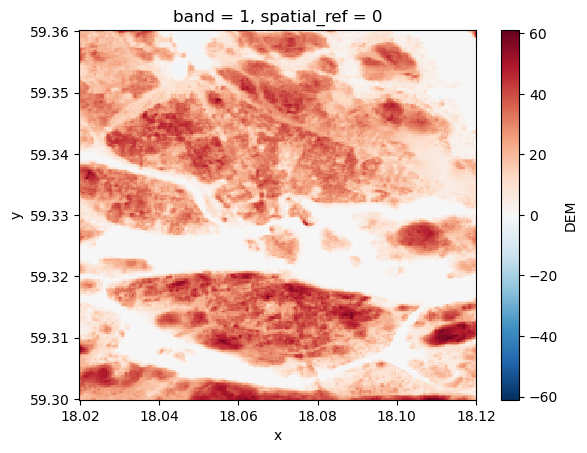

In [5]:
# Make a quick plot
elevation_raster.plot()

In [6]:
# Print basic statistics
print(f"Min value: {elevation_raster.min().item()}")
print(f"Max value: {elevation_raster.max().item()}")
print(f"Mean value: {elevation_raster.mean().item()}")
print(f"Median value: {elevation_raster.median().item()}")
print(f"Standard deviation: {elevation_raster.std().item()}")

Min value: -4.2309699058532715
Max value: 61.063838958740234
Mean value: 18.188512802124023
Median value: 17.99282455444336
Standard deviation: 13.968965530395508


# 🌍 Loading Raster Data through WMS

## 🛰️ What is WMS?
A **Web Map Service (WMS)** is a **standardized protocol** developed by the **Open Geospatial Consortium (OGC)** that allows users to request and retrieve **georeferenced raster images** over the internet. WMS is widely used in **GIS applications** to serve and consume raster data, including satellite imagery, elevation models, and topographic maps.

Unlike **raw raster datasets (GeoTIFF, NetCDF, etc.)**, WMS typically provides **pre-rendered map images** in common formats such as:
- **PNG / JPEG** → Used for quick map visualization
- **GeoTIFF** → Used for geospatial analysis and raster data processing

Organizations such as **government agencies, research institutions, and mapping providers** host WMS services to distribute **publicly available geospatial datasets**.

---

## 📌 Retrieving Elevation Data via WMS

### **1️⃣ Example: Fetching a Digital Elevation Model (DEM)**
Let's explore an example of how to retrieve **Digital Elevation Model (DEM)** data using WMS. In this case, we use **USGS 3DEP**, a public dataset providing high-resolution elevation data for the U.S.

### **2️⃣ Connecting to the WMS Server**
To access **DEM data via WMS**, we first need to **connect to a valid WMS endpoint**. In our example, we use the **USGS 3DEP WMS**:



Available WMS layers:
  3DEPElevation - 3DEPElevation
  3DEPElevation:Hillshade Gray - 3DEPElevation:Hillshade Gray
  3DEPElevation:Aspect Degrees - 3DEPElevation:Aspect Degrees
  3DEPElevation:Aspect Map - 3DEPElevation:Aspect Map
  3DEPElevation:Contour 25 - 3DEPElevation:Contour 25
  3DEPElevation:Hillshade Elevation Tinted - 3DEPElevation:Hillshade Elevation Tinted
  3DEPElevation:Hillshade Multidirectional - 3DEPElevation:Hillshade Multidirectional
  3DEPElevation:Preset 2ft Contour Interval - 3DEPElevation:Preset 2ft Contour Interval
  3DEPElevation:Preset 5ft Contour Interval - 3DEPElevation:Preset 5ft Contour Interval
  3DEPElevation:Preset 10ft Contour Interval - 3DEPElevation:Preset 10ft Contour Interval
  3DEPElevation:Slope Map - 3DEPElevation:Slope Map
  3DEPElevation:Slope Degrees - 3DEPElevation:Slope Degrees
  3DEPElevation:Contour Smoothed 25 - 3DEPElevation:Contour Smoothed 25
  3DEPElevation:None - 3DEPElevation:None


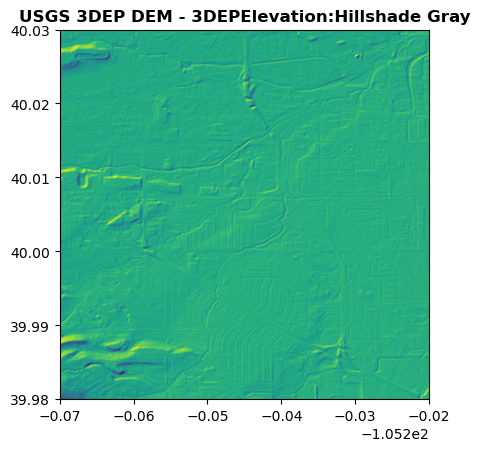

In [10]:
import requests
from owslib.wms import WebMapService
from io import BytesIO
import rasterio
from rasterio.plot import show

# ✅ Step 1: Define the USGS 3DEP WMS URL
wms_url = "https://elevation.nationalmap.gov/arcgis/services/3DEPElevation/ImageServer/WMSServer"

# ✅ Step 2: Connect to the WMS Service
wms = WebMapService(wms_url, version="1.3.0")

# ✅ Step 3: Print Available Layers (Check for DEM)
print("Available WMS layers:")
for layer_name, layer_obj in list(wms.contents.items()):
    print(f"  {layer_name} - {layer_obj.title}")

# ✅ Step 4: Select the DEM
selected_layer = "3DEPElevation:Hillshade Gray"  # This is the actual elevation layer

# ✅ Step 5: Define Bounding Box (Ensure it's inside the USA)
bbox = (-105.27, 39.98, -105.22, 40.03)  # Example: Small area in Colorado

# ✅ Step 6: Issue a GetMap Request for DEM
wms_request = wms.getmap(
    layers=[selected_layer],
    srs='EPSG:4326',  # Coordinate Reference System
    bbox=bbox,
    size=(800, 800),
    format='image/tiff',  # Requesting TIFF format for DEM instead of PNG
    transparent=True
)

# ✅ Step 7: Fetch the DEM Data
response = requests.get(wms_request.geturl())

# ✅ Step 8: Open and Plot the DEM if the request is successful
if response.status_code == 200:
    with rasterio.open(BytesIO(response.content)) as src:
        show(src, title=f"USGS 3DEP DEM - {selected_layer}")
else:
    print(f"Failed to retrieve DEM data. HTTP {response.status_code}")


# 🛰️ Loading a Multiband Raster File

In GIS and remote sensing, **multiband raster files** are commonly used to store satellite imagery. Each band represents a different **wavelength of the electromagnetic spectrum**, such as:
- **Red, Green, and Blue (RGB)** for true-color images
- **Near-Infrared (NIR)** for vegetation analysis
- **Shortwave Infrared (SWIR)** for water and soil moisture detection

In a **multiband raster**, each pixel contains multiple values, corresponding to **reflectance** in different spectral bands.

---

## 📂 **Example: Sentinel-2 Image Over Stockholm**
For this section, we will explore **how to load and visualize a multiband raster file** using a **Sentinel-2 satellite image of Stockholm (`data/Central_Stockholm_Sentinel2_2023_RGB_NIR.tif`)**.


## 🖥️ **Loading and Visualizing the Sentinel-2 Raster**
To work with **multiband raster data**, we use Python libraries like:
- **`rasterio`** – For reading raster files
- **`matplotlib`** – For visualizing raster data
- **`rioxarray`** – For advanced raster analysis with `xarray`



In [11]:
import rioxarray
import matplotlib.pyplot as plt
import numpy as np

Stockholm_sentinel_path = "data/Central_Stockholm_Sentinel2_2023_RGB_NIR.tif"

# Load the multiband raster file
Stockholm_sentinel = rioxarray.open_rasterio(Stockholm_sentinel_path)

(array([5.266300e+05, 1.389398e+06, 7.241190e+05, 2.172140e+05,
        8.294300e+04, 2.714900e+04, 1.160700e+04, 1.894000e+03,
        7.800000e+01, 3.200000e+01]),
 array([1210., 1713., 2216., 2719., 3222., 3725., 4228., 4731., 5234.,
        5737., 6240.]),
 <BarContainer object of 10 artists>)

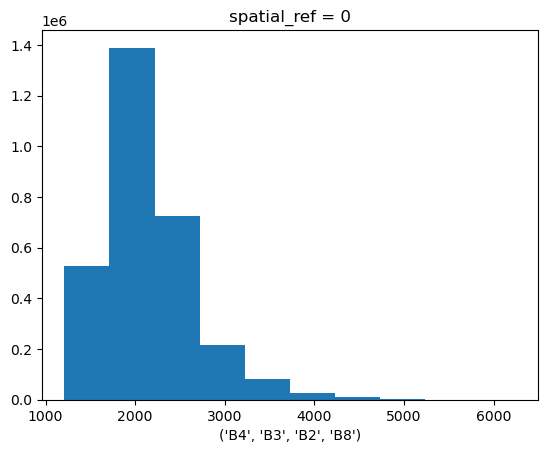

In [12]:
Stockholm_sentinel.plot()

When you attempt to plot a multiband raster using the plot() function, xarray treats the data as a multi-dimensional array rather than a geospatial raster. As a result, it generates a summary visualization, such as a bar chart, instead of displaying the expected raster image. This occurs because xarray doesn’t inherently recognize the dataset as geospatial and tries to plot all bands together.

To properly visualize the raster, you’ll need to plot individual bands or create an RGB composite. But before doing that, let's first examine the metadata:

In [13]:
print(Stockholm_sentinel)

<xarray.DataArray (band: 4, y: 669, x: 1114)> Size: 24MB
[2981064 values with dtype=float64]
Coordinates:
  * band         (band) int32 16B 1 2 3 4
  * x            (x) float64 9kB 18.02 18.02 18.02 18.02 ... 18.12 18.12 18.12
  * y            (y) float64 5kB 59.36 59.36 59.36 59.36 ... 59.3 59.3 59.3 59.3
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('B4', 'B3', 'B2', 'B8')


The dataset has **4 bands**, each with a spatial resolution of **669 pixels in height (`y`) and 1114 pixels in width (`x`)**.  
The total dataset size is **24MB**.

The raster contains **floating-point (`float64`) values**

The `long_name` attribute specifies that the dataset contains **four spectral bands**:
- **B4 (Red)**
- **B3 (Green)**
- **B2 (Blue)**
- **B8 (Near Infrared - NIR)**

The `x` and `y` coordinates represent **geospatial positions**

- **Minimum & Maximum Values:** Range from **1358 to 4339**  
- **Mean & Standard Deviation:** Mean reflectance value is **1903.62**, with a standard deviation of **382.98**  
- **100% valid pixels**, meaning no missing data  
- **Scale Factor & Offset:** Set to **1.0 and 0.0**, implying values are stored in their raw form  

[European Space Agency (ESA) Sentinel-2 User Guide](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/resolutions/radiometric) 


In [14]:
# Access red band
red_band = Stockholm_sentinel.sel(band=4)

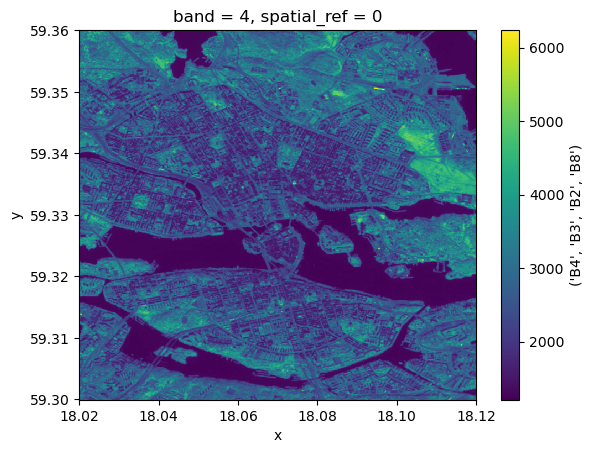

In [15]:
red_band.plot()

# What is a Multiband Composite?

A **multiband composite** is an image created by combining multiple spectral bands from a satellite or aerial sensor into a single visual representation. Since satellites like **Sentinel-2** capture light in different wavelengths beyond what the human eye can see (e.g., infrared, shortwave infrared), compositing bands allows us to visualize and analyze Earth’s surface in meaningful ways.

## **RGB Composite for Sentinel-2**

- **Red Channel → Band 4 (Red)**
- **Green Channel → Band 3 (Green)**
- **Blue Channel → Band 2 (Blue)**

This combination produces an image that closely resembles what our eyes would see.

## **False-Color Composites**
Sometimes, different band combinations are used to highlight specific features:

- **Infrared Vegetation (False-Color RGB):**  
  `B8 (NIR), B4 (Red), B3 (Green)` – Helps in vegetation analysis.
  



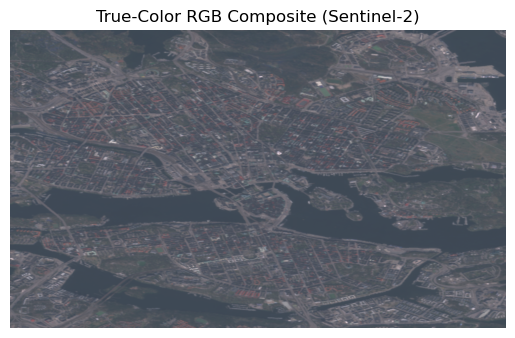

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Define band mapping based on the dataset metadata
band_mapping = {'B4': 1, 'B3': 2, 'B2': 3, 'B8': 4}

# Select bands by their Sentinel-2 names
red_band = Stockholm_sentinel.sel(band=band_mapping['B4'])  # B4 (Red)
green_band = Stockholm_sentinel.sel(band=band_mapping['B3'])  # B3 (Green)
blue_band = Stockholm_sentinel.sel(band=band_mapping['B2'])  # B2 (Blue)

# Stack the bands together to create an RGB composite
rgb_image = np.dstack((red_band.values, green_band.values, blue_band.values))

# Normalize the image values between 0 and 1
rgb_image = rgb_image / np.max(rgb_image)

# Plot the RGB composite image
plt.imshow(rgb_image)
plt.title("True-Color RGB Composite (Sentinel-2)")
plt.axis('off')  # Hide the axis for better visualization
plt.show()


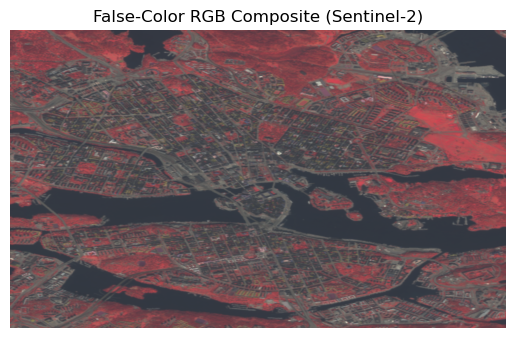

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Define band mapping based on the dataset metadata
band_mapping = {'B4': 1, 'B3': 2, 'B2': 3, 'B8': 4}

# Select bands by their Sentinel-2 names
red_band = Stockholm_sentinel.sel(band=band_mapping['B8'])  # B8 (Infrared)
green_band = Stockholm_sentinel.sel(band=band_mapping['B4'])  # B4 (Red)
blue_band = Stockholm_sentinel.sel(band=band_mapping['B3'])  # B3 (Green)

# Stack the bands together to create an RGB composite
rgb_image = np.dstack((red_band.values, green_band.values, blue_band.values))

# Normalize the image values between 0 and 1
rgb_image = rgb_image / np.max(rgb_image)

# Plot the RGB composite image
plt.imshow(rgb_image)
plt.title("False-Color RGB Composite (Sentinel-2)")
plt.axis('off')  # Hide the axis for better visualization
plt.show()
